# Fine-Tuning Vision Transformers for Image Classification through timm

The goal of this notebook is to create an image classifier for sattelite images, using timm (and pytorch) on the EUROSAT dataset.
We will fine-tune a Vision Transformer (ViT), as research shows this is the best appraoch for multi-class classification [1].

Adapted from: https://www.kaggle.com/code/hinepo/transfer-learning-with-timm-models-and-pytorch

# Installs

Preprend ! to run in colab

Might use VSCODE_PID to check for where execution takes place

In [ ]:
!pip install timm torchvision albumentations

In [ ]:
!pip install torchmetrics pytorch_accelerated

# Importing

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import time
import random # for torch seed
import os # for torch seed

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

from PIL import Image

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import torchvision

# CFG

This class enables easy configuration to simulate and understand results.

You can tweak some parameters and see how they impact on the metrics, plots, and predictions.

In [5]:
class CFG:
  OUTPUT_PATH = './'

  ### split train and validation sets
  split_fraction = 0.8

  ### model
  model_name = 'vit_tiny_patch16_224' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...

  ### training
  print_freq = 100
  BATCH_SIZE = 16
  N_EPOCHS = 10

  ### set only one to True
  save_best_loss = False
  save_best_accuracy = True

  ### optimizer
  # optimizer = 'adam'
  optimizer = 'adamw'
  # optimizer = 'rmsprop'
  LEARNING_RATE = 2e-4
  weight_decay = 0.1 # for adamw
  l2_penalty = 0.01 # for RMSprop
  rms_momentum = 0 # for RMSprop

  ### learning rate scheduler (LRS)
  scheduler = 'ReduceLROnPlateau'
  # scheduler = 'CosineAnnealingLR'
  plateau_factor = 0.5
  plateau_patience = 3
  cosine_T_max = 4
  cosine_eta_min = 1e-8
  verbose = True

  ### train and validation DataLoaders
  shuffle = False

  ### albumentations
  probability = 0.6

  random_seed = 42

In [6]:
# detect and define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [7]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

# Transfer Learning: timm

In [8]:
### check model structure
model = timm.create_model(CFG.model_name, pretrained = True)

In [9]:
# Define a transformation on the dataset to match the resolution of the model
transform_std = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
print(transform_std)

Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)


# Data

## Dataset

In [10]:
# Turning off necessary in Google Colab: https://github.com/pytorch/vision/issues/5039
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# https://pytorch.org/vision/stable/generated/torchvision.datasets.EuroSAT.html
dataset = torchvision.datasets.EuroSAT("./", download = True)

100%|██████████| 94280567/94280567 [00:05<00:00, 16796345.87it/s]


Extracting ./eurosat/EuroSAT.zip to ./eurosat


In [11]:
len(dataset)

27000

In [12]:
# Classes in train dataset
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [13]:
# Adapt classificaiton head of model
num_classes = len(dataset.classes)
model.reset_classifier(num_classes)
# print last layer
model.get_classifier()

Linear(in_features=192, out_features=10, bias=True)

In [14]:
# Image shape
image = Image.open(dataset.imgs[0][0]).convert('RGB')
torchvision.transforms.functional.get_image_size(image)

[64, 64]

## Split

In [15]:
### random split

# sklearn's train_test_split runs out of memory on GC.
#train_ds, valid_ds = train_test_split(dataset, test_size=(1-CFG.split_fraction), random_state=CFG.random_seed)

train_len = int(CFG.split_fraction * len(dataset))
lengths = [train_len , len(dataset) - train_len]
train_ds, valid_ds = torch.utils.data.random_split(dataset, lengths)

len(train_ds), len(valid_ds)

(21600, 5400)

In [16]:
# Check on image size
# Still a PIL image as no transformations have been applied
(train_ds[0][0].width, train_ds[0][0].height)

(64, 64)

## Data Augmentation

In [17]:
train_transform = timm.data.create_transform(
    **resolve_data_config(model.pretrained_cfg, model=model),
    is_training=True,
    auto_augment="rand-m7-mstd0.5-inc1",
)
print(train_transform)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=PosterizeIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=SolarizeIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=ColorIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=ContrastIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=BrightnessIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=SharpnessIncreasing, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=7, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=7, mstd=0.5))
    ToTensor()
    Norm

In [18]:
val_transform = timm.data.create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
print(val_transform)

Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)


In [19]:
# Apply seprate transformation to each subset
# Source: https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_ds = MyDataset(train_ds, transform=train_transform)
valid_ds = MyDataset(valid_ds, transform=val_transform)

# Training

## Optimizer

Function to get the optimizer to be used (can be tuned in CFG class).

In [20]:
def get_optimizer(lr = CFG.LEARNING_RATE):

  if CFG.optimizer == 'adam':
      optimizer = Adam(model.parameters(), lr=lr, weight_decay = CFG.weight_decay, amsgrad = False)

  elif CFG.optimizer == 'adamw':
      optimizer = AdamW(model.parameters(), lr = lr, weight_decay = CFG.weight_decay)

  elif CFG.optimizer == 'rmsprop':
      optimizer = RMSprop(model.parameters(), lr = lr, weight_decay = CFG.l2_penalty, momentum = CFG.rms_momentum)

  else:
      print('Optimizer is not defined')

  return optimizer

## LR Scheduler

In [21]:
def get_scheduler(optimizer):

  if CFG.scheduler=='ReduceLROnPlateau':
      scheduler = ReduceLROnPlateau(optimizer, mode='max', factor = CFG.plateau_factor, patience = CFG.plateau_patience, verbose = CFG.verbose)

  elif CFG.scheduler=='CosineAnnealingLR':
      scheduler = CosineAnnealingLR(optimizer, T_max = CFG.cosine_T_max, eta_min = CFG.cosine_eta_min)

  else:
      print('LR Scheduler is not defined')

  return scheduler

## Train function

In [22]:
def train_fn(train_loader, model, criterion, optmizer, device):
  # switch to train mode
  model.train()


  size = len(train_loader.dataset)
  num_batches = len(train_loader)

  loss, correct = 0, 0

  ################################# train #################################

  for batch, (X, y) in enumerate(train_loader):

    start = time.time()

    device = torch.device(device)
    X, y = X.to(device), y.to(device)

    # compute predictions and loss
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.long().squeeze())
    current = batch * len(X)

    # Backpropagation: only in train function, not done in validation function
    loss.backward()
    optimizer.step()

    # sum correct predictions
    y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
    correct += (y_pred == y_true).type(torch.float).sum().item()

    end = time.time()
    time_delta = np.round(end - start, 3)

    # log
    loss, current = np.round(loss.item(), 5), batch * len(X)
    # if batch % (CFG.print_freq) == 0:
    #   print(f"Train Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

## Validation function

Use it when you are sure you will not call Tensor.backward(). It reduces memory and time consumption.

In [23]:
def valid_fn(valid_loader, model, criterion, device):
  model.eval()

  size = len(valid_loader.dataset)
  num_batches = len(valid_loader)

  loss, correct = 0, 0

  ################################# validation #################################

  with torch.no_grad(): # disable gradients
    for batch, (X, y) in enumerate(valid_loader):

      start = time.time()

      device = torch.device(device)
      X, y = X.to(device), y.to(device)

      # compute predictions and loss
      pred = model(X)
      loss = criterion(pred, y.long().squeeze())
      current = batch * len(X)

      # sum correct predictions
      y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
      correct += (y_pred == y_true).type(torch.float).sum().item()

      end = time.time()
      time_delta = np.round(end - start, 3)

      # log
      loss, current = np.round(loss.item(), 5), batch * len(X)
      # if batch % (CFG.print_freq) == 0:
      #   print(f"Valid Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

In [23]:
class DigitModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model_name = model
        self.cnn = model

    def forward(self, x):
        x = self.cnn(x)
        return x
model=DigitModel()

# Run training

In [26]:
start = time.time()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# instantiate model
device = torch.device(device)
model = model.to(device) # move the model to GPU before constructing optimizers for it

print('\n ******************************* Using backbone: ', CFG.model_name, " ******************************* \n")

# define optimizer
optimizer = get_optimizer(lr = CFG.LEARNING_RATE)

# define scheduler
scheduler = get_scheduler(optimizer)

# prepare dataset
train_dataloader = DataLoader(train_ds,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)

valid_dataloader = DataLoader(valid_ds,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)


train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []
LR_history = []

best_loss = np.inf
best_epoch_loss = 0
best_acc = 0
best_epoch_acc = 0

print('Starting Training...\n')

start_train_time = time.time()

for epoch in range(0, CFG.N_EPOCHS):
  print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
  start_epoch_time = time.time()

  # train
  train_loss, train_acc = train_fn(train_dataloader, model, loss_fn, optimizer, device)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  # validation
  valid_loss, valid_acc = valid_fn(valid_dataloader, model, loss_fn, device)
  valid_loss_history.append(valid_loss)
  valid_acc_history.append(valid_acc)

  # apply LR scheduler after each epoch
  if isinstance(scheduler, ReduceLROnPlateau):
      scheduler.step(valid_loss)

  elif isinstance(scheduler, CosineAnnealingLR):
      scheduler.step()

  # save LR value to plot later
  for param_group in optimizer.param_groups:
    LR_history.append(param_group['lr'])

  # save validation loss if it was improved (reduced)
  if valid_loss < best_loss:
    best_epoch_loss = epoch + 1
    best_loss = valid_loss
    if CFG.save_best_loss:
      # save the model's weights and biases only if CFG.save_best_loss == True
      torch.save(model.state_dict(), CFG.OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth")

  # save validation accuracy if it was improved (increased)
  if valid_acc > best_acc:
    best_epoch_acc = epoch + 1
    best_acc = valid_acc
    if CFG.save_best_accuracy:
      # save the model's weights and biases only if CFG.save_best_accuracy == True
      torch.save(model.state_dict(), CFG.OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth")

  end_epoch_time = time.time()
  time_delta = np.round(end_epoch_time - start_epoch_time, 3)
  print("\n\nEpoch Elapsed Time: {} s".format(time_delta))

end_train_time = time.time()
print("\n\nTotal Elapsed Time: {} min".format(np.round((end_train_time - start_train_time)/60, 3)))
print("Done!")


 ******************************* Using backbone:  vit_tiny_patch16_224  ******************************* 

Starting Training...


-------------------------------   Epoch 1   -------------------------------

Train: Accuracy: 77.36%, Avg loss: 0.000980 

Valid: Accuracy: 88.33%, Avg loss: 0.001335 



Epoch Elapsed Time: 183.064 s

-------------------------------   Epoch 2   -------------------------------

Train: Accuracy: 81.30%, Avg loss: 0.000572 

Valid: Accuracy: 89.98%, Avg loss: 0.001647 



Epoch Elapsed Time: 182.893 s

-------------------------------   Epoch 3   -------------------------------

Train: Accuracy: 82.64%, Avg loss: 0.000463 

Valid: Accuracy: 92.41%, Avg loss: 0.000403 



Epoch Elapsed Time: 183.614 s

-------------------------------   Epoch 4   -------------------------------

Train: Accuracy: 83.54%, Avg loss: 0.000249 

Valid: Accuracy: 93.35%, Avg loss: 0.000525 



Epoch Elapsed Time: 184.643 s

-------------------------------   Epoch 5   ------------------

## Plot Epochs

Plot Train and Validation Loss and Accuracy for each Epoch.

In [28]:
print('Best loss: ', best_loss)
print('Best epoch (loss criteria): ', best_epoch_loss)
print('\n')
print('Best accuracy: ', best_acc)
print('Best epoch (accuracy criteria): ', best_epoch_acc)

Best loss:  4.4674556213017755e-05
Best epoch (loss criteria):  10


Best accuracy:  0.9685185185185186
Best epoch (accuracy criteria):  9


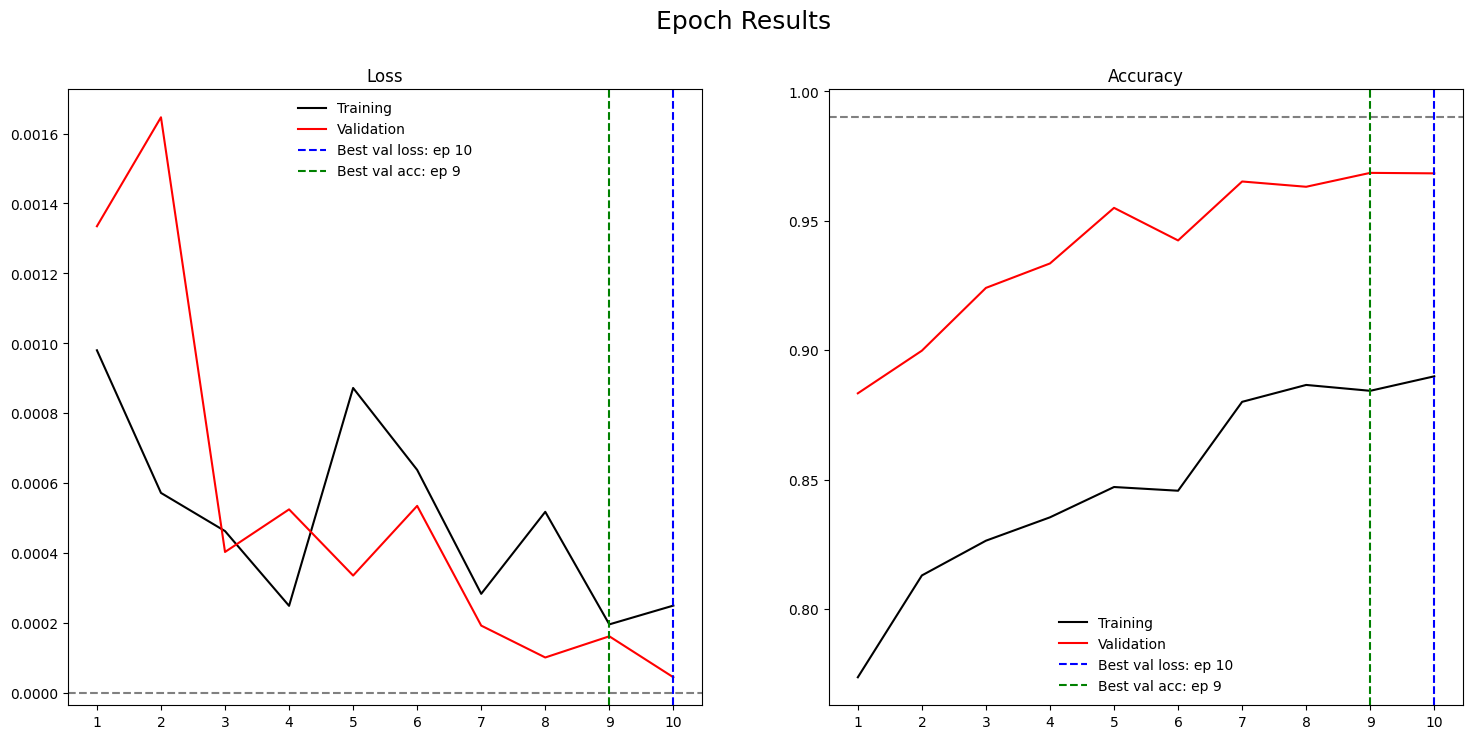

In [29]:
fig = plt.figure(figsize = (18, 8))
fig.suptitle('Epoch Results', fontsize = 18)

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# Loss plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abscissa, train_loss_history, label='Training', color = 'black')
ax1.plot(abscissa, valid_loss_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Loss")
ax1.legend(frameon=False);

# Accuracy plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(abscissa, train_acc_history, label='Training', color = 'black')
ax2.plot(abscissa, valid_acc_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0.99, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Accuracy")
ax2.legend(frameon=False);

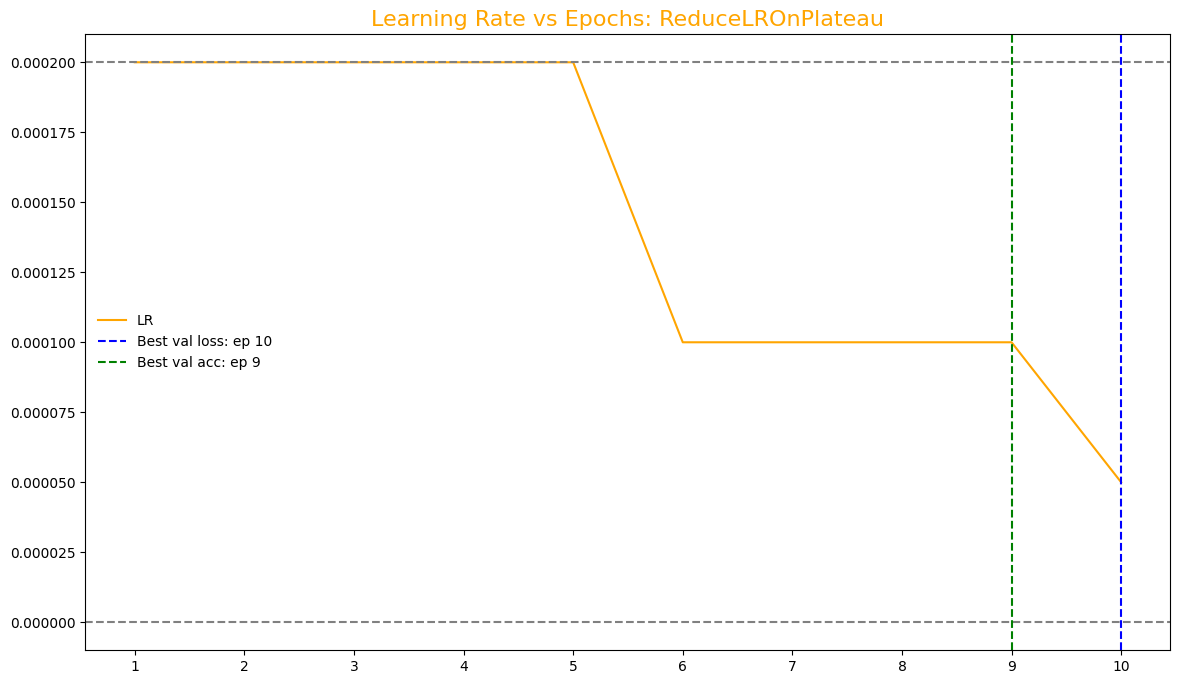

In [30]:
fig = plt.figure(figsize = (14, 8))

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# LR plot
plt.plot(abscissa, LR_history, label='LR', color = 'orange')
plt.xticks(x_ticks)
plt.axhline(CFG.LEARNING_RATE, linestyle = 'dashed', color = 'grey')
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title(f"Learning Rate vs Epochs: {CFG.scheduler}", fontsize = 16, color = 'orange')
plt.legend(frameon=False);

## Results

First, note that the train accuracy is lower than expected due to the use of data augmentation, which is only active on the training set.

The performance of the model is higher than the fast ai method, but lower than the Hugging Face method. This means that the performance is lower than the reference [1], which can be attributed to the use of the tiny variant of ViT.

There are a few potential reasons for other differences:
1. Difference in the train-test-validation split
2. Optimizer settings: no hyperparameter tuning, limited number of epochs
3. Data augmentation

All points should be further cheched against the paper. We could apply a hyperparameter tuning & continue the training for more epochs to alleviate points 2.

# Alternative Training

Alternative training procedure, which supports a few more advanced functionalities:
* Using pytorch_accelerated
* MixUp data augmentation.
* Model EMA

Source: [Towards Data Science](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055)

In [24]:
import torchmetrics
from timm.optim.optim_factory import create_optimizer_v2
from timm.loss import BinaryCrossEntropy
from timm.scheduler import CosineLRScheduler

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

INFO:pytorch_accelerated:Setting random seeds


In [25]:
class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )
        self.accuracy.reset()
        self.ema_accuracy.reset()

In [26]:
class TimmTrainer(Trainer):
    def __init__(self, eval_loss_fn, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None

        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def train_epoch_end(
        self,
    ):

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.accuracy.update(outputs.argmax(-1), yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.accuracy.reset()

In [29]:
def main():
    # Set training arguments, hardcoded here for clarity
    smoothing = 0.1
    mixup = 0.2
    cutmix = 1.0
    bce_target_thresh = 0.2

    mixup_args = dict(
        mixup_alpha=mixup,
        cutmix_alpha=cutmix,
        label_smoothing=smoothing,
        num_classes=num_classes,
    )

    # Create model using timm
    model = timm.create_model(
        CFG.model_name, pretrained=False, num_classes=num_classes, drop_path_rate=0.05
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    device = torch.device(device)
    model = model.to(device) # move the model to GPU before constructing optimizers for it

    # Create optimizer
    optimizer = create_optimizer_v2(
        model, opt="AdamW", lr=CFG.LEARNING_RATE
    )

    # As we are using Mixup, we can use BCE during training and CE for evaluation
    train_loss_fn = BinaryCrossEntropy(
        #target_threshold=bce_target_thresh,
        smoothing=smoothing
    )
    train_loss_fn = torch.nn.CrossEntropyLoss()
    validate_loss_fn = torch.nn.CrossEntropyLoss()

    # Create trainer and start training
    trainer = TimmTrainer(
        model=model,
        optimizer=optimizer,
        loss_func=train_loss_fn,
        eval_loss_fn=validate_loss_fn,
        #mixup_args=mixup_args,
        num_classes=num_classes,
        callbacks=[
            *DEFAULT_CALLBACKS,
            SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
        ],
    )

    trainer.train(
        per_device_batch_size=CFG.BATCH_SIZE,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        num_epochs=CFG.N_EPOCHS,
        create_scheduler_fn=trainer.create_scheduler,
    )

In [ ]:
main()

cuda

Starting training run

Starting epoch 1


100%|██████████| 1350/1350 [02:17<00:00,  9.84it/s]



train_loss_epoch: 1.7438749074935913


100%|██████████| 338/338 [00:20<00:00, 16.84it/s]



accuracy: 0.5859259366989136

eval_loss_epoch: 1.1673822402954102

Starting epoch 2


100%|██████████| 1350/1350 [02:14<00:00, 10.06it/s]



train_loss_epoch: 1.4410638809204102


100%|██████████| 338/338 [00:17<00:00, 19.82it/s]



accuracy: 0.7075926065444946

eval_loss_epoch: 0.8996589183807373

Starting epoch 3


100%|██████████| 1350/1350 [02:20<00:00,  9.61it/s]



train_loss_epoch: 1.2228455543518066


100%|██████████| 338/338 [00:18<00:00, 18.22it/s]



accuracy: 0.6475926041603088

eval_loss_epoch: 0.9939463138580322

Starting epoch 4


100%|██████████| 1350/1350 [02:17<00:00,  9.80it/s]



train_loss_epoch: 1.0623611211776733


100%|██████████| 338/338 [00:15<00:00, 21.47it/s]

## Results

A few variants were tried. Results after 10 epochs:

* Standard version of algorithm: 0.79
* No BCE threshold: 0.854
* No MixUp: 0.875
* No EMA: 0.875
* Batch size & weight_decay
* drop_path_rate


# Other Training algorithms
There are two more alternatives for training algorithms:
1. A more compact (but also relatively basic) training routine could be composed from: https://timm.fast.ai/Optimizers, especially by lifting the limitation for training only 1 epoch.
2. Use the [official training script](https://huggingface.co/docs/timm/training_script), though giving probably the best results, it would aloow less learning :)

# Conclusion

While the results for the first training method are good (96.85%), the second training method did not succeed.

Note that the results are better than the ones attained with fast ai, while using the same base model (ViT-tiny), also not pretrained on ImageNet21K (which is advised by [1]).

## Evaluation

The use of timm instead of plain pytorch is practical for:
1. The image transformation and data augmentation (handled in the same object)
2. Loading an existing model

Having a special timm training function is not necessarily worth it, unless using the official training script.

This code should be relatively easy to adapt to plain PyTorch code if an existing ViT model can be accessed from it.

# References

[1] Ivica Dimitrovski, Ivan Kitanovski, Dragi Kocev, Nikola Simidjievski, Current trends in deep learning for Earth Observation: An open-source benchmark arena for image classification,
ISPRS Journal of Photogrammetry and Remote Sensing, Volume 197, 2023, Pages 18-35, ISSN 0924-2716, https://doi.org/10.1016/j.isprsjprs.2023.01.014. (https://www.sciencedirect.com/science/article/pii/S0924271623000205)